<a href="https://colab.research.google.com/github/tomasdevelopment/ufc-predictions-ml/blob/main/ufc_predictions_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, textwrap, pathlib, itertools
print(os.listdir('/content/drive'))         # should show 'MyDrive'
print(os.listdir('/content/drive/MyDrive/sportsanalytics')) # list root of your Drive
# top level
!ls -lah /content/drive/MyDrive/sportsanalytics

# # recursive (can be big)
# !find /content/drive/MyDrive -maxdepth 3 -type f -printf "%p\t%k KB\n" | head -n 200


Mounted at /content/drive
['MyDrive', '.shortcut-targets-by-id', '.Trash-0', '.Encrypted']
['Diplomagrado tom.pdf', 'ActaGradoTOmas.pdf', 'nhldraft.csv', 'nhlplayoffs.csv', 'ufc_detailed.csv', 'generalstats.csv', 'generalfightstats.csv', 'corr_fd_ortega_Over2p5.csv', 'corr_fp_ortega_Over2p5.csv', 'corr_fd_alj_win_Win.csv', 'corr_fp_alj_win_Win.csv', 'corr_fd_alj_sigmore_Alj_SigStr_More.csv', 'corr_fp_alj_sigmore_Alj_SigStr_More.csv', 'ufc_detailed.gsheet', 'ufc_detailed (1).gsheet']
total 2.2M
-rw------- 1 root root 256K Oct  4  2023  ActaGradoTOmas.pdf
-rw------- 1 root root   26 Aug 19 00:08  corr_fd_alj_sigmore_Alj_SigStr_More.csv
-rw------- 1 root root   26 Aug 19 00:08  corr_fd_alj_win_Win.csv
-rw------- 1 root root   26 Aug 19 00:08  corr_fd_ortega_Over2p5.csv
-rw------- 1 root root  858 Aug 19 00:08  corr_fp_alj_sigmore_Alj_SigStr_More.csv
-rw------- 1 root root  767 Aug 19 00:08  corr_fp_alj_win_Win.csv
-rw------- 1 root root 1.2K Aug 19 00:08  corr_fp_ortega_Over2p5.csv
-rw---

In [99]:
import pandas as pd

base = "/content/drive/MyDrive/sportsanalytics"

fighter_profile = pd.read_csv(f"{base}/generalstats.csv")
fights_detailed = pd.read_csv(f"{base}/ufc_detailed.csv")
fights_general  = pd.read_csv(f"{base}/generalfightstats.csv")

print(fighter_profile.shape, fights_detailed.shape, fights_general.shape)
fights_general.head()

(14, 3) (23, 16) (35, 12)


,Date,Fighter,Opponent,Result,Method,Event,Round,Time,KD,Strikes (F/O),Takedowns (F/O),Subs (F/O)
0,23-Aug-25,Aljamain Sterling,Brian Ortega,—,Scheduled,UFC Fight Night: Walker vs Zhang,—,—,—,—,—,—
1,7-Dec-24,Aljamain Sterling,Movsar Evloev,Loss,U-DEC,UFC 310: Pantoja vs Asakura,3,5:00,0–0,12–8,6–4,0–0
2,14-Sep-24,Brian Ortega,Diego Lopes,Loss,U-DEC,UFC 306: Riyadh Season Noche UFC,3,5:00,0–0,63–106,0–1,0–0
3,13-Apr-24,Aljamain Sterling,Calvin Kattar,Win,U-DEC,UFC 300: Pereira vs Hill,3,5:00,0–0,39–8,8–0,0–0
4,24-Feb-24,Brian Ortega,Yair Rodriguez,Win,SUB (Arm Triangle),UFC FN: Moreno vs Royval 2,3,0:58,0–1,28–55,3–0,1–0


Strikes_F       vs Over2p5: Pearson=0.634, Spearman=0.704 (n=34)


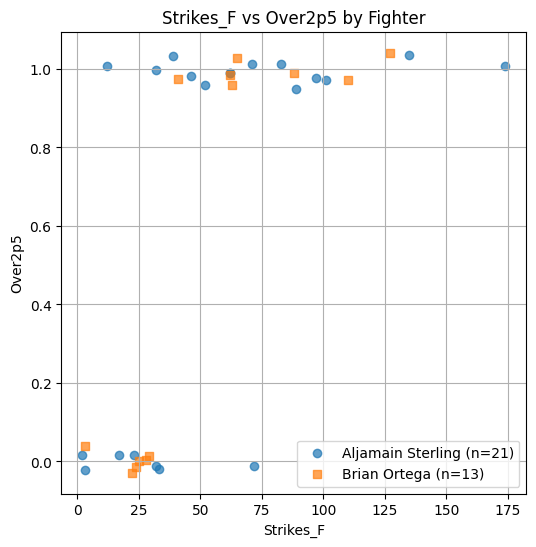

Strikes_O       vs Over2p5: Pearson=0.366, Spearman=0.469 (n=34)


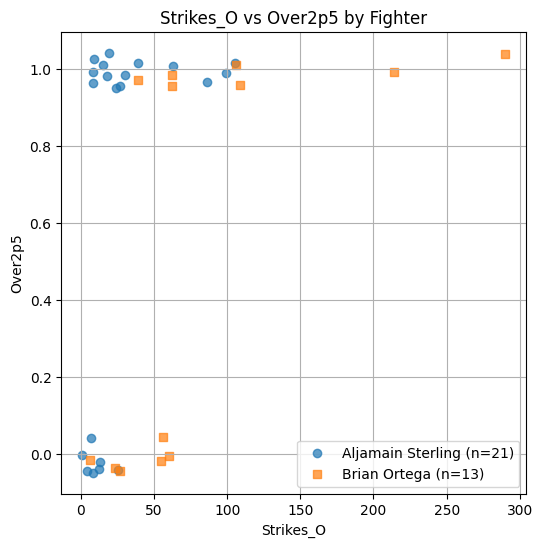

Takedowns_F     vs Over2p5: Pearson=0.173, Spearman=0.156 (n=34)


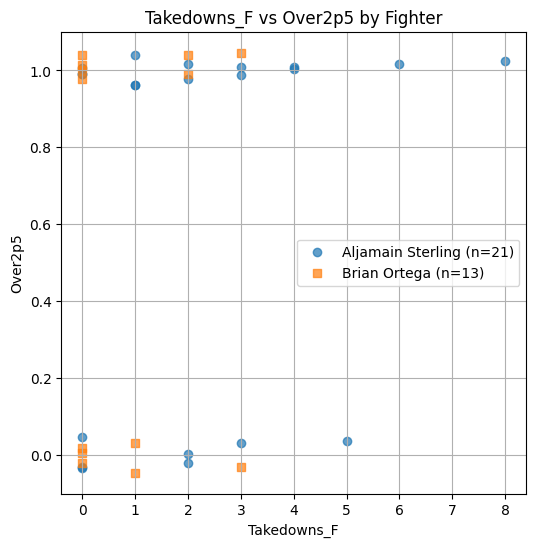

Takedowns_O     vs Over2p5: Pearson=0.327, Spearman=0.364 (n=34)


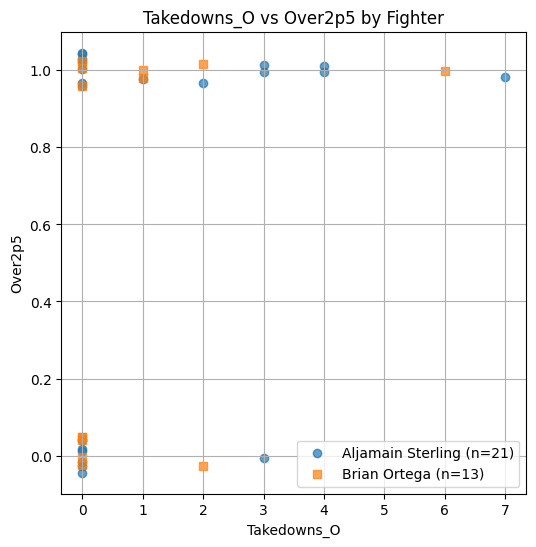

Subs_F          vs Over2p5: Pearson=-0.336, Spearman=-0.400 (n=34)


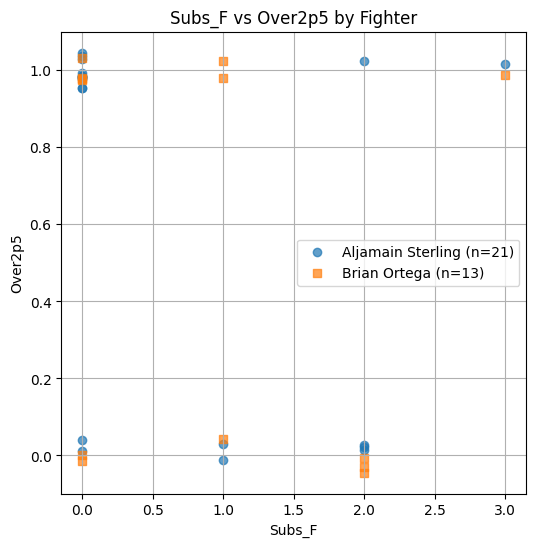

Subs_O          vs Over2p5: Pearson=0.137, Spearman=0.137 (n=34)


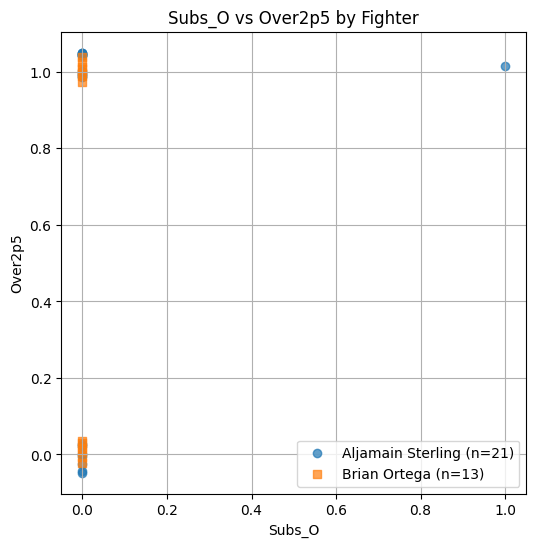

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
fights_general = fights_general.copy(deep=True)
# =====================
# Helpers
# =====================
def parse_pair(x):
    """Parse '12–8' or '0-0' into (F,O)."""
    if pd.isna(x):
        return (np.nan, np.nan)
    nums = [n for n in str(x).replace("–", "-").replace(" ", "").split("-") if n.isdigit()]
    if len(nums) == 2:
        return float(nums[0]), float(nums[1])
    return (np.nan, np.nan)

def safe_round(x):
    try:
        return float(x)
    except:
        return np.nan

def safe_time(x):
    """Convert '5:00' to seconds. Handles '—' safely."""
    if pd.isna(x) or str(x).strip() in {"—","-",""}:
        return np.nan
    m = pd.Series(str(x)).str.extract(r"(\d+):(\d+)")
    if m.isna().any(axis=None):
        return np.nan
    return int(m.iloc[0,0]) * 60 + int(m.iloc[0,1])

# =====================
# Feature engineering
# =====================
fights_general["Round_clean"] = fights_general["Round"].apply(safe_round)
fights_general["Time_clean"]  = fights_general["Time"].apply(safe_time)
fights_general["TotalSeconds"] = (fights_general["Round_clean"]-1)*300 + fights_general["Time_clean"]

# Target: did fight last >2.5 rounds
fights_general["Over2p5"] = (fights_general["TotalSeconds"]>=750).astype("Int64")

# Parse (F/O) stats
fights_general[["Strikes_F","Strikes_O"]]     = fights_general["Strikes (F/O)"].apply(lambda x: pd.Series(parse_pair(x)))
fights_general[["Takedowns_F","Takedowns_O"]] = fights_general["Takedowns (F/O)"].apply(lambda x: pd.Series(parse_pair(x)))
fights_general[["Subs_F","Subs_O"]]           = fights_general["Subs (F/O)"].apply(lambda x: pd.Series(parse_pair(x)))

# Win indicator
fights_general["Win"] = fights_general["Result"].str.startswith("W").astype(int)

# =====================
# Correlations + Two-Fighter Scatter Plots
# =====================
features = ["Strikes_F","Strikes_O","Takedowns_F","Takedowns_O","Subs_F","Subs_O"]
target = "Over2p5"
fighters = ["Aljamain Sterling", "Brian Ortega"]

for feat in features:
    sub = fights_general[[feat,target,"Fighter"]].dropna()
    sub = sub[sub["Fighter"].isin(fighters)]  # only these two
    if len(sub) < 3:
        continue

    r_p, _ = pearsonr(sub[feat], sub[target])
    r_s, _ = spearmanr(sub[feat], sub[target])
    print(f"{feat:15} vs {target}: Pearson={r_p:.3f}, Spearman={r_s:.3f} (n={len(sub)})")

    # jitter Y since it's binary
    y = sub[target] + (np.random.rand(len(sub))-0.5)*0.1

    plt.figure(figsize=(6,6))
    for fighter, marker in zip(fighters, ["o", "s"]):
        grp = sub[sub["Fighter"] == fighter]
        plt.scatter(
            grp[feat],
            y.loc[grp.index],
            alpha=0.7,
            marker=marker,
            label=f"{fighter} (n={len(grp)})"
        )

    plt.xlabel(feat); plt.ylabel(target)
    plt.title(f"{feat} vs {target} by Fighter")
    plt.grid(True)
    plt.legend()
    plt.show()


In [101]:
fights_general

,Date,Fighter,Opponent,Result,Method,Event,Round,Time,KD,Strikes (F/O),Takedowns (F/O),Subs (F/O),Round_clean,Time_clean,TotalSeconds,Over2p5,Strikes_F,Strikes_O,Takedowns_F,Takedowns_O,Subs_F,Subs_O,Win
0,23-Aug-25,Aljamain Sterling,Brian Ortega,—,Scheduled,UFC Fight Night: Walker vs Zhang,—,—,—,—,—,—,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0
1,7-Dec-24,Aljamain Sterling,Movsar Evloev,Loss,U-DEC,UFC 310: Pantoja vs Asakura,3,5:00,0–0,12–8,6–4,0–0,3.0,300.0,900.0,1,12.0,8.0,6.0,4.0,0.0,0.0,0
2,14-Sep-24,Brian Ortega,Diego Lopes,Loss,U-DEC,UFC 306: Riyadh Season Noche UFC,3,5:00,0–0,63–106,0–1,0–0,3.0,300.0,900.0,1,63.0,106.0,0.0,1.0,0.0,0.0,0
3,13-Apr-24,Aljamain Sterling,Calvin Kattar,Win,U-DEC,UFC 300: Pereira vs Hill,3,5:00,0–0,39–8,8–0,0–0,3.0,300.0,900.0,1,39.0,8.0,8.0,0.0,0.0,0.0,1
4,24-Feb-24,Brian Ortega,Yair Rodriguez,Win,SUB (Arm Triangle),UFC FN: Moreno vs Royval 2,3,0:58,0–1,28–55,3–0,1–0,3.0,58.0,658.0,0,28.0,55.0,3.0,0.0,1.0,0.0,1
5,19-Aug-23,Aljamain Sterling,Sean O’Malley,Loss,KO/TKO (Punches),UFC 292,2,0:51,0–1,17–25,0–0,0–0,2.0,51.0,351.0,0,17.0,25.0,0.0,0.0,0.0,0.0,0
6,6-May-23,Aljamain Sterling,Henry Cejudo,Win,S-DEC,UFC 288,5,5:00,0–0,135–99,4–3,0–0,5.0,300.0,1500.0,1,135.0,99.0,4.0,3.0,0.0,0.0,1
7,16-Jul-22,Brian Ortega,Yair Rodriguez,Loss,KO/TKO (Injury),UFC FN: Ortega vs Rodriguez,1,4:11,0–0,22–23,1–0,0–0,1.0,251.0,251.0,0,22.0,23.0,1.0,0.0,0.0,0.0,0
8,22-Oct-22,Aljamain Sterling,TJ Dillashaw,Win,KO/TKO (Punches),UFC 280,2,3:44,0–0,72–8,5–0,2–0,2.0,224.0,524.0,0,72.0,8.0,5.0,0.0,2.0,0.0,1
9,25-Sep-21,Brian Ortega,Alexander Volkanovski,Loss,U-DEC,UFC 266,5,5:00,0–0,88–214,2–0,3–0,5.0,300.0,1500.0,1,88.0,214.0,2.0,0.0,3.0,0.0,0


In [104]:
import pandas as pd
import numpy as np
import re
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# ========= 1) Clean + feature engineering on fights_general =========
fg = fights_general.copy()

# --- Split "(F/O)" columns robustly into *_F, *_O ---
def add_pair_columns(df, colname, prefix):
    # normalize/clean a bit first
    s = (df[colname].astype(str)
         .str.replace("\u2013", "-", regex=False)   # en dash
         .str.replace("\u2014", "-", regex=False)   # em dash
         .str.replace("—", "-", regex=False)        # long dash
         .str.replace(" ", "", regex=False))
    # extract two integers anywhere in the string
    out = s.str.extract(r'(\d+)\D+(\d+)')
    out = out.rename(columns={0: f"{prefix}_F", 1: f"{prefix}_O"}).astype(float)
    df[[f"{prefix}_F", f"{prefix}_O"]] = out
    return df

fg = add_pair_columns(fg, "Strikes (F/O)",   "Strikes")
fg = add_pair_columns(fg, "Takedowns (F/O)", "Takedowns")
fg = add_pair_columns(fg, "Subs (F/O)",      "Subs")

# --- TotalSeconds target ---
def safe_time_seconds(t):
    if pd.isna(t): return np.nan
    s = str(t).strip()
    if ":" not in s: return np.nan
    try:
        m, ss = s.split(":")
        return int(m)*60 + int(ss)
    except:
        return np.nan

def total_seconds(round_val, time_val):
    # handles strings like "3", ints, etc.
    try:
        r = int(str(round_val).strip())
    except:
        return np.nan
    ts = safe_time_seconds(time_val)
    if np.isnan(ts): return np.nan
    return (r-1)*300 + ts

fg["TotalSeconds"] = fg.apply(lambda r: total_seconds(r["Round"], r["Time"]), axis=1)
fg["Over2p5"] = (fg["TotalSeconds"] >= 750).astype("Int64")

# Keep only rows with a valid target and all features
features = ["Strikes_F","Strikes_O","Takedowns_F","Takedowns_O","Subs_F","Subs_O"]
model_df = fg.loc[
    fg["TotalSeconds"].notna() & fg[features].notna().all(axis=1)
].copy()

if len(model_df) < 6:
    raise ValueError(f"Not enough usable rows after cleaning (have {len(model_df)}).")

# ========= 2) Linear regression on TotalSeconds =========
X = model_df[features].astype(float).values
y = model_df["TotalSeconds"].astype(float).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33 if len(model_df) <= 24 else 0.2,
    random_state=42, shuffle=True
)

linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test  = linreg.predict(X_test)

print("== Linear Regression (TotalSeconds) ==")
print("Train MAE:", round(mean_absolute_error(y_train, y_hat_train), 2),
      "R2:", round(r2_score(y_train, y_hat_train), 3))
print("Test  MAE:", round(mean_absolute_error(y_test,  y_hat_test ), 2),
      "R2:", round(r2_score(y_test,  y_hat_test ), 3))

coef_table = pd.DataFrame({
    "feature": features,
    "weight_per_unit": linreg.coef_
}).sort_values("weight_per_unit", ascending=False)
print("\nFeature weights (seconds per unit):\n", coef_table)

# ========= 3) Convert to probability of Over 2.5 =========
# Assume residuals ~ N(0, sigma^2) estimated from train residuals
resid = y_train - y_hat_train
sigma = np.std(resid, ddof=1)
if sigma <= 1e-6:
    sigma = 1.0  # guardrail if tiny set

def prob_over_2p5_from_pred_seconds(y_hat, sigma):
    # P(Y >= 750) with Y ~ N(y_hat, sigma^2)
    z = (750 - y_hat) / sigma
    # 1 - Phi(z)
    return 0.5 * (1 - erf(z / np.sqrt(2))) + 0.5

# quick erf import (scipy not required)
from math import erf, sqrt

# Backtest classification via thresholding predicted seconds
model_df["y_hat"] = linreg.predict(model_df[features].values)
model_df["p_over25"] = model_df["y_hat"].apply(lambda v: prob_over_2p5_from_pred_seconds(v, sigma))
model_df["pred_over25"] = (model_df["y_hat"] >= 750).astype(int)
acc = (model_df["pred_over25"] == (model_df["TotalSeconds"] >= 750).astype(int)).mean()
print("\n== Backtest (threshold at 750s) ==")
print("Hit rate:", round(acc, 3))

# ========= 4) Pre-fight vector for Brian vs Aljamain (recent form blend) =========
def fighter_agg(df, fighter, last_n=5):
    d = df[df["Fighter"].astype(str).str.strip() == fighter].copy()
    d = d.loc[d["TotalSeconds"].notna()]
    if len(d) == 0:
        return (pd.Series({f:0.0 for f in ["Strikes_F","Takedowns_F","Subs_F"]}),
                pd.Series({f:0.0 for f in ["Strikes_O","Takedowns_O","Subs_O"]}))
    d = d.sort_values("Date")
    if last_n and len(d) > last_n:
        d = d.tail(last_n)
    off = d[["Strikes_F","Takedowns_F","Subs_F"]].mean(numeric_only=True).fillna(0.0)
    deff= d[["Strikes_O","Takedowns_O","Subs_O"]].mean(numeric_only=True).fillna(0.0)
    return off, deff

def blended_row(brian_off, brian_def, alja_off, alja_def, w=0.6):
    row = {
        "Strikes_F":   w*brian_off["Strikes_F"]   + (1-w)*alja_def["Strikes_O"],
        "Takedowns_F": w*brian_off["Takedowns_F"] + (1-w)*alja_def["Takedowns_O"],
        "Subs_F":      w*brian_off["Subs_F"]      + (1-w)*alja_def["Subs_O"],
        "Strikes_O":   w*brian_def["Strikes_O"]   + (1-w)*alja_off["Strikes_F"],
        "Takedowns_O": w*brian_def["Takedowns_O"] + (1-w)*alja_off["Takedowns_F"],
        "Subs_O":      w*brian_def["Subs_O"]      + (1-w)*alja_off["Subs_F"],
    }
    return pd.DataFrame([row])[features].astype(float)

brian_off, brian_def = fighter_agg(model_df, "Brian Ortega", last_n=5)
alja_off,  alja_def  = fighter_agg(model_df, "Aljamain Sterling", last_n=5)

X_upcoming = blended_row(brian_off, brian_def, alja_off, alja_def, w=0.6)
y_hat_upcoming = float(linreg.predict(X_upcoming)[0])
p_over25 = prob_over_2p5_from_pred_seconds(y_hat_upcoming, sigma)
fair_odds = 1.0 / max(p_over25, 1e-9)

print("\n== Upcoming: Brian Ortega vs Aljamain Sterling ==")
print(f"Predicted fight length (seconds): {y_hat_upcoming:.1f}")
print(f"P(Over 2.5 rounds) = {p_over25:.3f}")
print(f"Fair odds (decimal) = {fair_odds:.2f}")


== Linear Regression (TotalSeconds) ==
Train MAE: 151.06 R2: 0.716
Test  MAE: 258.52 R2: 0.277

Feature weights (seconds per unit):
        feature  weight_per_unit
5       Subs_O        98.411678
2  Takedowns_F        40.206579
3  Takedowns_O        38.565792
0    Strikes_F         6.906322
1    Strikes_O         0.559195
4       Subs_F       -34.798164

== Backtest (threshold at 750s) ==
Hit rate: 0.912

== Upcoming: Brian Ortega vs Aljamain Sterling ==
Predicted fight length (seconds): 771.6
P(Over 2.5 rounds) = 1.042
Fair odds (decimal) = 0.96


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [107]:
# ========= 5) Append predictions back to original df =========

fg_pred = fg.copy()

# only score historical rows for Brian Ortega (leave Aljamain rows untouched)
mask_features = fg_pred[features].notna().all(axis=1)
mask_brian    = fg_pred["Fighter"].astype(str).str.strip().eq("Brian Ortega")
mask_hist     = mask_features & mask_brian

# predict TotalSeconds -> prob/odds for Brian Ortega rows only
fg_pred.loc[mask_hist, "y_hat"] = linreg.predict(fg_pred.loc[mask_hist, features].values)
fg_pred.loc[mask_hist, "p_over25"] = fg_pred.loc[mask_hist, "y_hat"].apply(
    lambda v: prob_over_2p5_from_pred_seconds(v, sigma)
)
fg_pred.loc[mask_hist, "fair_odds"] = 1.0 / fg_pred.loc[mask_hist, "p_over25"].clip(lower=1e-9)

# inject the UPCOMING fight prediction on the scheduled row only (do not touch other Aljamain rows)
# y_hat_upcoming and p_over25 were computed earlier from the blended pre-fight vector
fair_odds_upcoming = 1.0 / max(p_over25, 1e-9)
mask_scheduled = fg_pred["Method"].astype(str).str.strip().eq("Scheduled")
fg_pred.loc[mask_scheduled, "p_over25"]  = p_over25
fg_pred.loc[mask_scheduled, "fair_odds"] = fair_odds_upcoming
# (optional) if you want to store the seconds prediction too:
fg_pred.loc[mask_scheduled, "y_hat"]     = y_hat_upcoming

# columns to export/view
cols_to_show = [
    "Date","Fighter","Opponent","Result","Method","Event",
    "Round","Time","Over2p5","p_over25","fair_odds"
]

df_fitted = fg_pred[cols_to_show].copy()
df_fitted.to_csv("fitted.csv", index=False)


[Exploded] sig_strikes_l             vs win: Pearson=0.534, Spearman=0.637 (n=23)


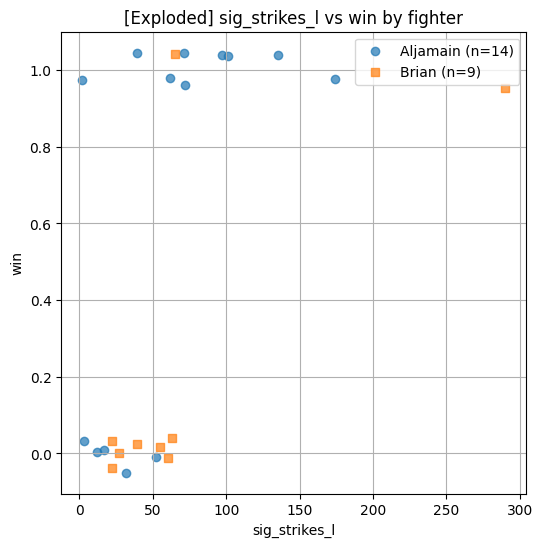

[Exploded] total_strikes_l           vs win: Pearson=0.657, Spearman=0.776 (n=20)


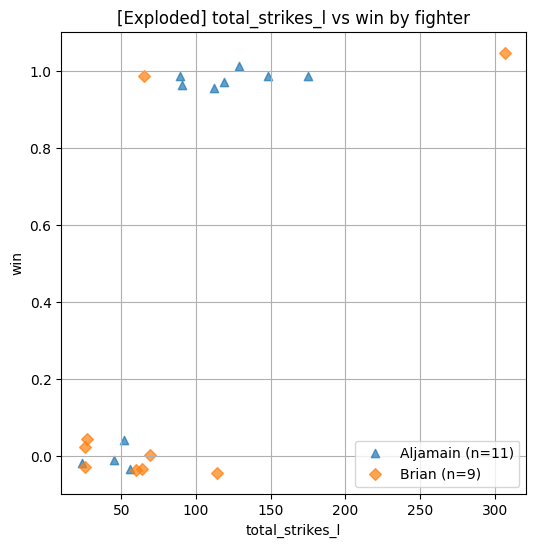

[Exploded] takedowns_l               vs win: Pearson=0.159, Spearman=0.218 (n=23)


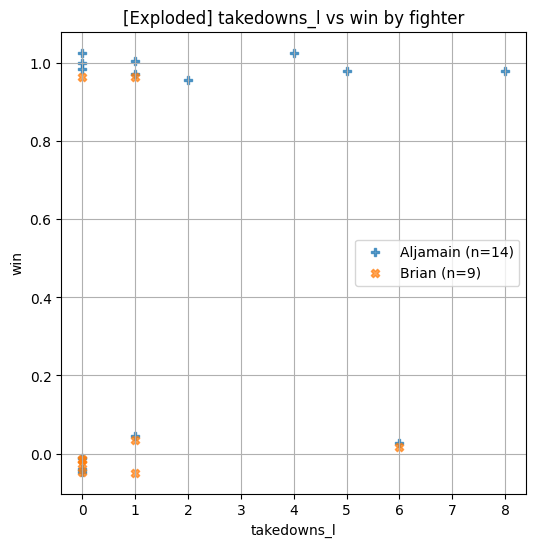

[Exploded] control_sec               vs win: Pearson=0.276, Spearman=0.231 (n=22)


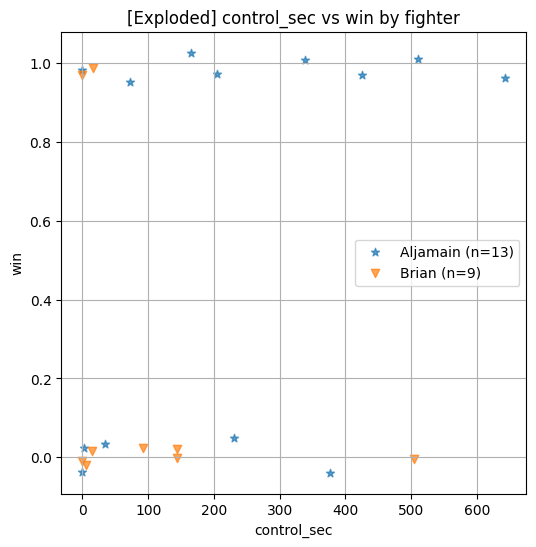

[Exploded] sig_strikes_opp_l         vs win: Pearson=0.365, Spearman=0.177 (n=23)


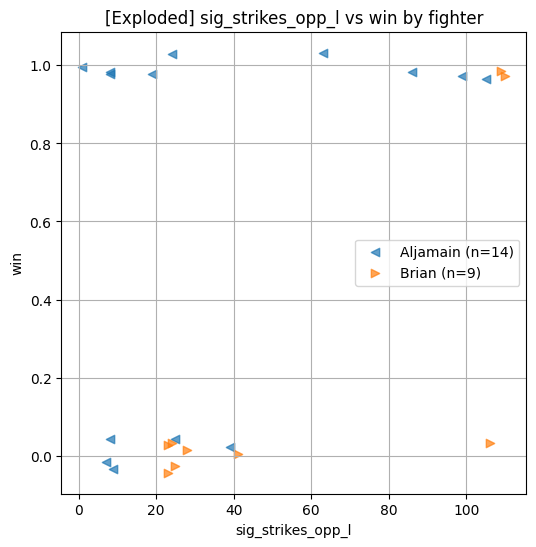

[Exploded] total_strikes_opp_l       vs win: Pearson=0.203, Spearman=0.101 (n=22)


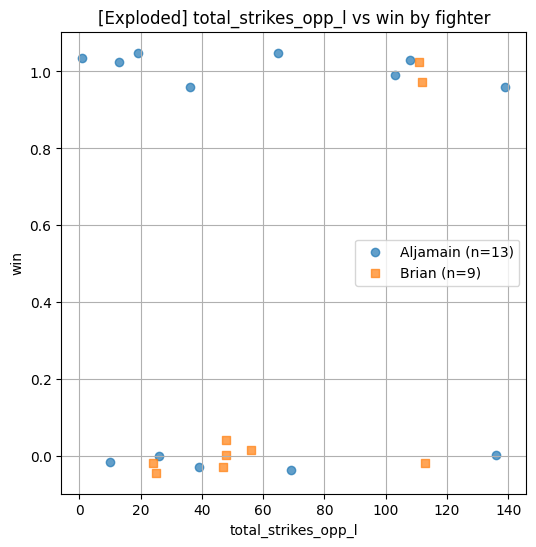

[Exploded] takedowns_opp_l           vs win: Pearson=0.151, Spearman=0.105 (n=23)


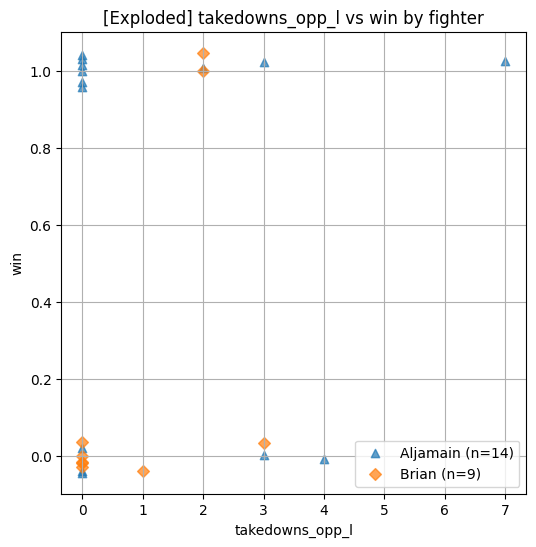

In [81]:
# =====================
# Grouped correlation plots (by fighter)
# =====================
from itertools import cycle
from itertools import cycle

def run_corrplots_bycat(
    df, features, target, cat_col, title_prefix="",
    min_points=3, top_k=None, cats_filter=None
):
    """
    Overlay scatter by category (e.g., fighter) on each feature's chart.
    - If cats_filter is given, it is treated as the *only* allowed set.
    - No hidden categories are reintroduced later by value_counts().
    """
    # Normalize category strings to avoid hidden dupes (trim/normalize)
    if df[cat_col].dtype == "object":
        df = df.copy()
        df[cat_col] = df[cat_col].astype(str).str.strip()

    # Determine allowed categories
    if cats_filter is not None:
        # Keep order the user provided, intersect with what actually exists
        cats_filter = [str(c).strip() for c in cats_filter]
        allowed_cats = [c for c in cats_filter if c in set(df[cat_col].unique())]
        df = df[df[cat_col].isin(allowed_cats)].copy()
    elif top_k is not None and top_k > 0:
        allowed_cats = list(df[cat_col].value_counts().head(top_k).index)
        df = df[df[cat_col].isin(allowed_cats)].copy()
    else:
        allowed_cats = list(df[cat_col].unique())

    marker_cycle = cycle(['o', 's', '^', 'D', 'P', 'X', '*', 'v', '<', '>'])

    for feat in features:
        cols_needed = [feat, target, cat_col]
        if not set(cols_needed).issubset(df.columns):
            continue

        sub = df[cols_needed].dropna()
        if len(sub) < 5:
            continue

        # Correlations (overall)
        try:
            r_p = sub[feat].corr(sub[target], method='pearson')
        except Exception:
            r_p = float('nan')
        try:
            r_s = sub[feat].corr(sub[target], method='spearman')
        except Exception:
            r_s = float('nan')

        print(f"{title_prefix}{feat:25} vs {target}: Pearson={r_p:.3f}, Spearman={r_s:.3f} (n={len(sub)})")

        # Jitter for binary target
        y = sub[target].copy()
        if y.nunique() <= 2:
            y = y + (np.random.rand(len(y)) - 0.5) * 0.1

        # Use ONLY the explicitly allowed categories; enforce min_points here
        cats_to_plot = []
        for c in allowed_cats:
            cnt = (sub[cat_col] == c).sum()
            if cnt >= min_points:
                cats_to_plot.append(c)

        # Map markers for the final cats only
        cat_to_marker = {c: next(marker_cycle) for c in cats_to_plot}

        plt.figure(figsize=(6, 6))
        for c in cats_to_plot:
            grp = sub[sub[cat_col] == c]
            y_grp = y.loc[grp.index]
            plt.scatter(
                grp[feat], y_grp,
                marker=cat_to_marker[c], alpha=0.7, label=f"{c} (n={len(grp)})"
            )

        plt.xlabel(feat); plt.ylabel(target)
        plt.title(f"{title_prefix}{feat} vs {target} by {cat_col}")
        plt.grid(True)
        if cats_to_plot:
            plt.legend(loc="best")
        plt.show()

# =====================
# Example usage on your exploded dataset
# =====================

# Pick a concise feature set to keep plots readable (you can expand later)
features_exploded = [
    "sig_strikes_l","total_strikes_l","takedowns_l","control_sec",
    "sig_strikes_opp_l","total_strikes_opp_l","takedowns_opp_l","control_opp_sec"
]

run_corrplots_bycat(
    fights_exploded,
    features=[
        "sig_strikes_l","total_strikes_l","takedowns_l","control_sec",
        "sig_strikes_opp_l","total_strikes_opp_l","takedowns_opp_l","control_opp_sec"
    ],
    target="win",
    cat_col="fighter",
    cats_filter=["Aljamain", "Brian"],  # exactly the two you want
    title_prefix="[Exploded] ",
    min_points=2
)


